In [1]:
import spacy
nlp = spacy.load("en_core_web_sm")
text = u'A man and a boy are playing computer and sitting on the ground in the office. A woman is presenting a chart and a picture. A boy sits on the chair and laughing at the dog. A boy sits on the chair and laughing. A boy stands laughing. A man and a boy are talking to each other. A girl is talking to his friend. There are some trees and plants and flowers in the park. An alien is standing. There lies a tree. A toy is played by a boy. A toy and a bear is played by a boy. Lying on the sofa. The boy plays in the park. A bench lies in the park.'
doc = nlp(text)
# 'he is '
# 'mike is'
# Invalid case:
# doc = nlp(u'A boy sits on the chair and plays games in home. A girl is watching.')
# doc = nlp(u'A man is sitting on a printer looking at his phone. A man and a woman are bending over to file.')
for token in doc:
    print("{2}({3}-{6}, {0}:{1}-{5})".format(token.text, token.tag_, token.dep_, token.head.text, token.head.tag_, token.i+1, token.head.i+1))
spacy.displacy.render(doc, style='dep')

det(man-2, A:DT-1)
nsubj(playing-7, man:NN-2)
cc(man-2, and:CC-3)
det(boy-5, a:DT-4)
conj(man-2, boy:NN-5)
aux(playing-7, are:VBP-6)
ROOT(playing-7, playing:VBG-7)
dobj(playing-7, computer:NN-8)
cc(playing-7, and:CC-9)
conj(playing-7, sitting:VBG-10)
prep(sitting-10, on:IN-11)
det(ground-13, the:DT-12)
pobj(on-11, ground:NN-13)
prep(sitting-10, in:IN-14)
det(office-16, the:DT-15)
pobj(in-14, office:NN-16)
punct(playing-7, .:.-17)
det(woman-19, A:DT-18)
nsubj(presenting-21, woman:NN-19)
aux(presenting-21, is:VBZ-20)
ROOT(presenting-21, presenting:VBG-21)
det(chart-23, a:DT-22)
dobj(presenting-21, chart:NN-23)
cc(chart-23, and:CC-24)
det(picture-26, a:DT-25)
conj(chart-23, picture:NN-26)
punct(presenting-21, .:.-27)
det(boy-29, A:DT-28)
nsubj(sits-30, boy:NN-29)
ROOT(sits-30, sits:VBZ-30)
prep(sits-30, on:IN-31)
det(chair-33, the:DT-32)
pobj(on-31, chair:NN-33)
cc(sits-30, and:CC-34)
conj(sits-30, laughing:VBG-35)
prep(laughing-35, at:IN-36)
det(dog-38, the:DT-37)
pobj(at-36, dog:NN-38)


In [2]:
# difficult cases:
##  "a man is sitting next to a desk": desk should be in surrounding (weak interaction)
##  "a man is watching a picture": picture should be in surrounding (weak interaction)
##  "a man is walking on a street": street should be in surrounding
### in all cases, the key is that there's no such combinations in the layer base

## solution: action intension detection -> explicitly comforms to the labeling convention

In [3]:
### entity -> coreference(typically same surroundings refers to the same one. But characters refer to different one.) -> infer subjects (in a missing nsubj case) -> infer relations (add it as long as there exists)

#### infer implicits:
## direct verbs can be a fixed edge
## indirect verb can be a variable edge. It can either be replaced or removed

In [4]:
# 4 nodes -> 6 edges -> 2^6 possible cases
# 2**6
# two expensive

In [5]:
## then how to partition nodes? all possible ways
# a man is talking to a woman -> group(have[man(talk) and woman(talk)]
# a man is watching chart -> man | chart (because there's no such combinations in the base)

In [6]:
# so this is a global optimization
# 4 nodes = 15 partitions
# 1 partion = 1~3 * 100 layer comparison

In [7]:
# infer implicits before or after partition?


In [8]:
# metric: still weighted IOU + verb relatedness

In [69]:
from spacy.matcher import Matcher
# from tools.text_process import SimpleLemmaTokenizer
import re
import itertools
import networkx as nx
from tools.containers import LayerName, Picture

# from collections import defaultdict
# from spacy.tokens.span import Span
# from tools.containers import LayerName, Picture
# from tools.common import ddict2dict
# from tools.instance import Node
MISSED = ''
UNK = '<UNK>'

class GraphParser:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")
    
    def get_verb_phrase(self):
        """
        self-defined verb phrase matcher
        """
        matcher = Matcher(self.doc.vocab)
        pattern = [{"POS": "VERB"},
                   {"POS": {"IN": ["ADV","ADP","PART"]}, "OP": "*"}]
        matcher.add("Verb Phrase:", None, pattern)
        phrases = []
        for _, start, end in matcher(self.doc):
            phrase = self.doc[start:end]
            # remove single stop words such as 'is' 'are'
            if len(phrase) == 1:
                if phrase[0].is_stop:
                    continue

            # greedy match
            same_roots = [p for p in phrases if p.root == phrase.root]
            if same_roots:
                # there two phrase refering to same verb root. E.g. "sit on" and "sit"
                assert(len(same_roots) == 1)
                p_ = same_roots[0]
                if len(p_) < len(phrase):
                    # choose the longer one
                    phrases.remove(p_)
                    phrases.append(phrase)
            else:
                phrases.append(phrase)
        return phrases       

    def get_noun_phrase(self):
        """
        use internal noun phrase matcher
        """
        return list(self.doc.noun_chunks)
    
    def is_connect(self, nop, vp):
        """
        check if a noun phrase and a verb phrase is connected
        """
        for v in vp:
            # check if two are directly connected in the dependency tree
            if nop.root.head == v or v.head == nop.root:
                return nop.root.dep_
        #   this allow verbs to be reused, move to the end of the pipeline
        #     for c in np.conjuncts:
        #         if c.head == v:
        #             return c.dep_[1:]
        for v in vp.conjuncts:
            # conjuctions of verb can be connected to a noun phrase.
            # E.g. A is doing and making ...
            if nop.root.head == v or v.head == nop.root:
                # only allow subjects propagrate through
                #  E.g. A is doing B and making C.
                # C and doing shouldn't connect.
                if re.match(r'\D*subj\D*', nop.root.dep_):
                    return nop.root.dep_
        return None

    def to_subj_or_obj(self, dep, n, v):
        """
        translate tags in dependency tree to subject | object
            But this may not be correct in case of passive voice
        """
        if not dep: return None
        if re.match(r'\D*subj\D*', dep): return 'subj'
        if re.match(r'\D*obj\D*', dep): return 'obj'
        raise ValueError('Unexpected dependency tag! %s' % dep, n, v)
    
    def is_SVO(self, n1, n2, v):
        """
        determine the connection is valid in a subj-verb-obj form
            two connected subjects or two connected objs are invalid.
                ! E.g. a man and a boy are playing computer.
                    "man" and "boy" are not connected.
        """
        conns = [self.to_subj_or_obj(self.is_connect(n1, v), n1, v),
                 self.to_subj_or_obj(self.is_connect(n2, v), n2, v)]
        conns = [c for c in conns if c]
        # only if subj and obj occur together, SVO stands
        # which means conns contains different tags
        if len(set(conns)) == 2:
        # if len(conns) == 2:
            return True
        return False

    def is_reverse(self, n1, n2):
        """
        if the leading noun is in passive voice, exchange them
        """
        # n1 must be the leading token
        assert(n1.root.i <= n2.root.i), (n1, n2)
        if re.match(r'\D*pass$', n1.root.dep_): return True
        if re.match(r'\D*subj\D*', n2.root.dep_):
            if re.match(r'\D*obj\D*', n1.root.dep_):
                return True
        return False

    def conjunts_expand(self, conns, nps):
        """
        The conjunctions of nouns share the same verbs and objects
        E.g. "A man and a boy are playing computer."
            boy will be conjuncted to man
        """
        conns_c = []
        for n1, n2, dic in conns:
            for c in n1.conjuncts:
                for n_ in nps:
                    if c in n_:
                        conns_c.append((n_, n2, dic))
            for c in n2.conjuncts:
                for n_ in nps:
                    if c in n_:
                        conns_c.append((n1, n_, dic))
        conns.extend(conns_c)
        return conns
            
    def get_edges(self, nouns, verbs):
        """
        if passive, needs to rectify the order
        Given nouns and verbs, infer connections in between
        """
        connections = []
        # nouns_ = nouns.copy()
        _verbs = []
        for n1, n2 in itertools.combinations(nouns, 2):
            for v in verbs:
                if self.is_SVO(n1, n2, v):
                    if self.is_reverse(n1, n2):
                        n1, n2 = n2, n1
                    connections.append((n1, n2, {'verb': v}))
                    # connections.append((n1, n2, v))
                    _verbs.append(v)
                    # if n1 in nouns_: nouns_.remove(n1)
                    # if n2 in nouns_: nouns_.remove(n2)
        self.conjunts_expand(connections, nouns)
        return connections, [v for v in verbs if v not in _verbs] #, nouns_

    def append_verbs(self, verbs, nouns):
        """
        absorb verbs with no subject or object
        """
        # print(verbs, nouns)
        noun_comps = []
        _verbs = []
        for v in verbs:
            for n in nouns:
                # if n.root.text == 'alien': print(n,v)
                # print(v)
                if self.is_connect(n, v):
                # if n.root in v.root.children:
                    # print(n,v)
                    noun_comps.append((n, {'verb': v}))
                    # noun_comps.append((n, v))
                    _verbs.append(v)
        return noun_comps, [v for v in verbs if v not in _verbs]
    
    def __call__(self, text):
        # parse text
        self.doc = self.nlp(text)
        self.nouns_ = self.get_noun_phrase()
        self.verbs_ = self.get_verb_phrase()
        self.edges_, self.rest_verbs_ = self.get_edges(self.nouns_,
                                                       self.verbs_)
        self.noun_comps_, self.rest_verbs_ = self.append_verbs(self.rest_verbs_, self.nouns_)
        
        # generate graph
        self.G = nx.Graph()
        self.G.add_nodes_from(self.nouns_)
        self.G.add_nodes_from(self.noun_comps_)
        self.G.add_edges_from(self.edges_)
        self.G = nx.freeze(self.G)
        assert(nx.is_frozen(self.G))
        
    def plot(self, style='networkx', **kwargs):
        if style == 'networkx':
            self.plot_network(**kwargs)
        elif style == 'layername':
            self.plot_triplets(**kwargs)
        else:
            raise KeyError('Available style: networkx and layername')
        
    def plot_network(self, edge=False):
        """
        Use networkx's graph plot
        """
        nx.draw(self.G, with_labels=True, 
                font_weight='bold', node_size=50)
        
        if edge:
            pos = nx.spring_layout(self.G)
            # nx.draw_networkx_nodes(G, pos=pos, node_size=50)
            # nx.draw_networkx_labels(G, pos=pos)
            # nx.draw_networkx_edges(G, pos=pos, edge_color='k', width=1)
            edge_labels = nx.get_edge_attributes(self.G,'verb')
            nx.draw_networkx_edge_labels(self.G, pos=pos,
                                         edge_labels=edge_labels)
        
    def get_triplets(self):
        triple_set = [(n1, e, n2) for n1, n2, e in parser.G.edges(data='verb')]
        entity_set = [(n, a, None) for n, a in parser.G.nodes(data='verb')]
        return triple_set + entity_set
    
    def plot_triplets(self, collapse=False):
        """
        call layerName.plot to plot triplets
        """
        def to_node(span, attr, reset=False):
            if not span:
                return Node(MISSED, attr=attr)
            i = i=span.root.i
            if reset: i = 0
            return Node(span.root.lemma_, i=i, attr=attr)
            # return Node(span.root.lemma_, i=0, attr=attr, count=1)

    #     def get_keyword(n):
    #         # if not n: return None
    #         assert(n.keyword), n
    #         return n.keyword

        def to_nested_entities(triplets):
            nested_entities = defaultdict(lambda: defaultdict(set))
            for n1, v, n2 in triplets:
                nested_entities[to_node(n1, 'subj')][to_node(v, 'act')].add(to_node(n2, 'obj'))
            return ddict2dict(nested_entities)

        if not collapse:
            nested_entities = to_nested_entities(self.get_triplets())
            layer = LayerName.from_nested_entities(nested_entities)
            layer.plot()
        else:        
            # layer = LayerName
            layers = []
            for n1, v, n2 in self.get_triplets(): #parser.edges_:
                nested_entities = defaultdict(lambda: defaultdict(set))
                nested_entities[to_node(n1, 'subj', reset=True)][to_node(v, 'act', reset=True)].add(to_node(n2, 'obj', reset=True))
                layer = LayerName.from_nested_entities(ddict2dict(nested_entities))
                # print(layer.nested_entities_)
                layers.append(layer)
            picture = Picture.from_layers(layers)
            picture.plot()
                
parser = GraphParser()
parser(text)

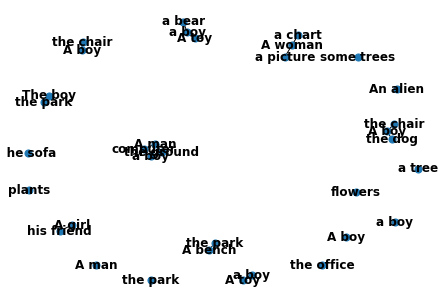

In [54]:
parser.plot(style='networkx')

In [8]:
# we could modify the dep_ tags
## so: if passive, reverse the order and give correct tag
##     if conj, inherit the tag from its parent
## knowledge:
##     fill in missing ends
##     assign subject object tag according to the knowledge, in this way we don't need to modify dep_ tags
# doc[0].dep_ = 'n'
# doc[0].dep_

In [9]:
# still needs coreference resolution
# senior subjects take all the objects
# but rest subjects still got the verb

### layerbase knowledge

In [55]:
from collections import defaultdict
from tools.common import getElementFromSet
from tools.instance import Node
from tools.knowledge import LayerBase

class VocabBase(LayerBase):
    
    def __init__(self):
        super().__init__()
        self.nouns_ = self._nouns()
        self.verbs_ = self._verbs()
        # verb_base = set(layerbase.entities_['act'].keys())
        
    def _nouns(self):
        return set(self.entities_['subj'].keys()) | \
               set(self.entities_['obj'].keys())
    
    def _verbs(self):
        verb_base = defaultdict(set)
        for tup in self.triples_:
            if len(tup) == 1: continue
            if len(tup) == 2:
                act = tup[1]
                assert(act.attr == 'act')
                if act in verb_base:
                    act_ = getElementFromSet(verb_base, act)
                    act_.count += 1
                else:
                    verb_base[act._reset()] = set()
            if len(tup) == 3:
                act, obj = tup[1], tup[2]
                assert(act.attr == 'act')
                if act in verb_base:
                    act_ = getElementFromSet(verb_base, act)
                    act_.count += 1
                else:
                    verb_base[act._reset()] = set()
                if obj in verb_base[act]:
                    obj_ = getElementFromSet(verb_base[act], obj)
                    obj_.count += 1
                else:
                    verb_base[act._reset()].add(obj._reset())
        return verb_base
    
    def get_intension(self, act, verbose=False):
        if act not in self.verbs_:
            return 0
        n_total = getElementFromSet(self.verbs_, act).count
        n_strong = sum([t.count for t in self.verbs_[act]])
        # n_weak = n_total - n_strong
        intension = n_strong / n_total
        if verbose:
            print('Intension: %.3f' % intension)
        return intension

In [56]:
vocabbase = VocabBase()

doneimages/product_teardown.svg]   



In [57]:
print(len(vocabbase.triples_))
            
print(getElementFromSet(vocabbase.verbs_, Node('have','act')).count)
print(sum([t.count for t in vocabbase.verbs_[Node('have','act')]]))
print(getElementFromSet(vocabbase.verbs_, Node('watch','act')).count)
print(sum([t.count for t in vocabbase.verbs_[Node('watch','act')]])) 

455
184
184
10
4


### graph ground

In [58]:
from tools.instance import CombToken
from tools.common import QuerySimi, getElementFromSet

class VerbNode(Node):
    """
    inherited from node, allow intension
    """
    def __init__(self, intension=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.intension = intension

        
class Grounder:
    
    def __init__(self, vocabbase):
        self.query = QuerySimi()
        self.base = vocabbase
        
    def ground(self, G):
        assert(isinstance(G, nx.classes.graph.Graph))
        return nx.freeze(self.ground_action(self.ground_entity(G)))
        
    def get_simi_keyword(self, token, keywords, thresh=0.3):
        assert(isinstance(keywords, set))
        assert(isinstance(list(keywords)[0], Node))
        assert(isinstance(token, spacy.tokens.token.Token))
        tups = [(k, self.query(token.lemma_, k.t)) for k in keywords]
        simi_key, simi_ = sorted(tups, key=lambda x: (x[1], x[0].count))[-1]
        if simi_ >= thresh:
            if simi_key.attr == 'act':
                # use token lemma
                return CombToken(token,
                                 Node(token.lemma_, simi_key.attr))
            else:
                # use keyword name in base
                # use token.i to resolve conflict
                return CombToken(token,
                                 Node(simi_key.t, simi_key.attr, token.i))
        if list(keywords)[0].attr == 'act':
            return CombToken(token, VerbNode(UNK, attr='act'))
        else:
            # todo - may need to specify either attrbute here to comform to the convention
            return CombToken(token, VerbNode(UNK, attr='[subj|obj]'))

    def ground_entity(self, g):
        """
        require noun base
        """
        mapping = {}
        for node in g.nodes:
            mapping[node] = self.get_simi_keyword(node.root, self.base.nouns_)
        return nx.relabel_nodes(g, mapping)

    def ground_action(self, g_):
        """
        require verb base
        """
        g = g_.copy()
        for u, v, e in g.edges(data='verb'):
            combtoken = self.get_simi_keyword(e.root, set(self.base.verbs_.keys()))
            g[u][v]['verb'] = combtoken
            g[u][v]['intension'] = self.base.get_intension(combtoken.keyword, verbose=False)
        for u, a in g.nodes(data='verb'):
            if a:
                combtoken = self.get_simi_keyword(a.root,
                                             set(self.base.verbs_.keys()))
                g.node[u]['verb'] = combtoken
                # g.node[u]['intension'] = get_intension(combtoken.keyword, verbose=False)
                # intension should be bound with verb each.
                # Will not use it.
        return g 

In [59]:
grounder = Grounder(vocabbase)

Loading GloVe model.. 
Loaded.
Loading related dict..


**can use graph plotter to visualize here**

In [61]:
H = grounder.ground(parser.G)
# verb_base
for a, b in zip(list(H.edges(data='intension')),
                list(H.edges(data='verb'))):
    print(a, b[-1])
# print()
# list(G.edges(data='intension'))[-3][-1]

(man->man, computer->computer, 1.0) play->play
(man->man, ground->ground, 0.0) sit->sit
(boy->man, computer->computer, 1.0) play->play
(boy->man, ground->ground, 0.0) sit->sit
(woman->woman, chart->chart, 0.0) present->present
(woman->woman, picture->pictures, 0.0) present->present
(boy->man, chair->chair, 0.0) sit->sit
(boy->man, dog->toy, 0) laugh->laugh
(boy->man, chair->chair, 0.0) sit->sit
(girl->woman, friend->man, 0.0) talk->talk
(toy->toy, boy->man, 1.0) play->play
(toy->toy, boy->man, 1.0) play->play
(bear->wild, boy->man, 1.0) play->play
(boy->man, park->park, 1.0) play->play
(bench->chair, park->park, 0.0) lie->lie


### object flow

In [70]:
class TripletGenerator:
    """
    accepts a graph, return a triplet combination generator
    """
    
    def __init__(self, G):
        assert(isinstance(G, nx.classes.graph.Graph))
        self.G = G
        
        from rules import labels
        self.subj_dict = labels.subjects

    def get_generator(self):
        fixed_set = self.get_triples(strong_only=True)

        for weak_comb in self.get_weak_triples():
            comb_set = [self.rectify(*tup) for tup in self.ravel_comb(weak_comb)]
            yield comb_set + fixed_set
            
    def is_strong(self, n1, n2):
        return self.G[n1][n2]['intension'] > 0.5

    def is_weakly_connected(self, n):
        for n_ in self.G.neighbors(n):
            if self.is_strong(n_, n):
                return False
        return True

    def is_subj(self, n):
        return n.keyword.attr == 'subj'

    def is_obj(self, n):
        return n.keyword.attr == 'obj'

    def get_weak_triples(self):
        subjs = [cn for cn in self.G.nodes if self.is_subj(cn)]
        objs = [cn for cn in self.G.nodes if self.is_obj(cn) and self.is_weakly_connected(cn)]
        # print('subjs: ', subjs)
        # print('flexible objs: ', objs)
    
        matrix = []
        for o in objs:
            li = []
            # first add the orignial weakly connected triplets as a possibility
            ## object connected to multiple subjects should be considered simutaneously
            all_weaks = []
            for s in self.G.neighbors(o):
                if not self.is_strong(s, o) and self.is_subj(s):
                    all_weaks.append((s, self.G[s][o]['verb'], o))
            if all_weaks:
                li.append(tuple(all_weaks))

            # then for each other non-neighour subjects, try bind this object to
            for s in subjs:

                # skip its parent subjects, already captured above
                if s in self.G.neighbors(o):
                    continue

                # objects cannot flow between characters
                if any([s_.keyword.t in self.subj_dict['character'] for s_ in self.G.neighbors(o)]) and s.keyword.t in self.subj_dict['character']:
                    continue

                li.append((s, None, o))

            # object can have no subject. make the base suggest a subject
            li.append((None, None, o))
            matrix.append(li)

        for comb in itertools.product(*tuple(matrix)):
            yield comb
            
    def reorder(self, n1, e, n2):
        """
        reorder the triplet such that the first is always a subject
            and better be a character if a deuce
        """
        if n1 and n2:
            # if both subjects, make sure n1 is character
            if self.is_subj(n1) and self.is_subj(n2):
                if n2.keyword.t in self.subj_dict['character']:
                    return (n2, e, n1)
            if self.is_obj(n1):
                assert(self.is_subj(n2)), n2
                return (n2, e, n1)
            # this to make sure only n1 will be checked
            # if n1 and n2 are both subjects, e.g. bear -> wild accidentally
            # then keep the order
            return (n1, e, n2)
        if n1:
            if self.is_obj(n1):
                return (n2, e, n1)
            return (n1, e, n2)
        # only explicitly check n2 when n1 is None
        if n2:
            if self.is_subj(n2):
                return (n2, e, n1)
        return (n1, e, n2)

    def filter_none(self, tup):
        tup_ = []
        for c, attr in zip(tup, ['subj', 'act', 'obj']):
            tup_.append(c if c else CombToken(None, Node(MISSED, attr=attr)))
        return tuple(tup_)

    def rectify(self, n1, e, n2):
        return self.filter_none(self.reorder(n1, e, n2))

    def ravel_comb(self, triplets_):
        triplets = []
        for t in triplets_:
            if isinstance(t[0], tuple):
                triplets.extend([*t])
            else:
                triplets.append(t)
        return triplets

    def get_triples(self, strong_only=False):

        ## all the edges, i.e. triplets
        if strong_only:
            triple_set = [self.rectify(n1, e, n2) for n1, n2, e in self.G.edges(data='verb') if self.is_strong(n1, n2)]
        else:
            triple_set = [self.rectify(n1, e, n2) for n1, n2, e in self.G.edges(data='verb')]

        ## all the entities along with their associated verbs
        entity_set = [self.rectify(n, a, None) for n, a in self.G.nodes(data='verb')]
        return triple_set + entity_set

In [71]:
generator = TripletGenerator(H)
triplets = next(generator.get_generator())
triplets_orig = generator.get_triples()
print([t for t in triplets if t not in triplets_orig])
print([t for t in triplets_orig if t not in triplets])

[(man->man, ->, tree->tree), (man->man, ->, plant->plant), (man->man, ->, flower->flower), (man->man, ->, tree->tree), (man->man, ->, sofa->sofa)]
[(woman->woman, present->present, chart->chart), (friend->man, talk->talk, girl->woman)]


In [72]:
def plot_triplets(triplets):
    """
    call layerName.plot to plot triplets
    """
    def to_node(span, attr):
        return Node(span.root.lemma_, i=span.root.i, attr=attr)
        # return Node(span.root.lemma_, i=0, attr=attr, count=1)

    def get_keyword(n):
        # if not n: return None
        assert(n.keyword), n
        return n.keyword

    def to_nested_entities(triplets):
        nested_entities = defaultdict(lambda: defaultdict(set))
        for n1, v, n2 in triplets:
            nested_entities[get_keyword(n1)][get_keyword(v)].add(get_keyword(n2))
        return ddict2dict(nested_entities)

    layer = LayerName.from_nested_entities(to_nested_entities(triplets))
    layer.plot()

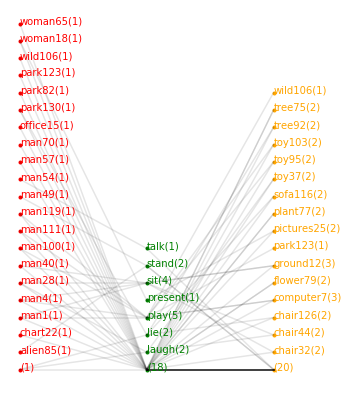

In [73]:
plot_triplets(triplets)

In [80]:
# do we need to consider <missed subject> under character?

# one problem is that all isolated objects have the same subject MISS
## means they can only be assigned the same object

from more_itertools import set_partitions

class LayerGenerator:
    def __init__(self, H):
        from rules import labels
        self.subj_dict = labels.subjects
        self.triplet_generator = TripletGenerator(H).get_generator()
    
    def get_generator(self):
        for triplets in self.triplet_generator:
            nested_entities = self.to_nested_entities(triplets)
            triplet_dict = self.to_triplet_dict(nested_entities)
            for layers in self.get_layers(triplet_dict):
                yield layers

    def to_nested_entities(self, triplets):
        nested_entities = defaultdict(lambda: defaultdict(set))
        for n1, v, n2 in triplets:
            nested_entities[n1][v].add(n2)
        return ddict2dict(nested_entities)

    def to_triplet_dict(self, nested_entities):
        triplet_dict = {'character': [],
                        'surrounding': [],
                        'unidentified': []}
        for key in nested_entities:
            if key.keyword.t != MISSED:
                if key.keyword.t in self.subj_dict['character']:
                    triplet_dict['character'].append({key: nested_entities[key]})
                elif key.keyword.t in  self.subj_dict['surrounding']:
                    triplet_dict['surrounding'].append({key: nested_entities[key]})
                else:
                    raise KeyError('Subject not found! %s' % key)
            else:
                triplet_dict['unidentified'].append({key: nested_entities[key]})
        return triplet_dict

    def merge_tuple(self, tup):
        dic_ = {}
        for dic in tup:
            for key in dic:
                dic_[key] = dic[key].copy()
        return dic_

    # def split_dict(dic):
    #     tup = []
    #     for key in dic:
    #         tup.append({key: dic[key]})
    #     return tuple(tup)

    def get_layers(self, triplet_dict):
        # each non-character subject form one layer
        fixed_layers = tuple(triplet_dict['surrounding'])
        fixed_layers += tuple(triplet_dict['unidentified'])

        # character subjects can be merged into a group
        for n_parts in range(1, len(triplet_dict['character'])+1):    
            for s in set_partitions(triplet_dict['character'], n_parts):
                char_layers = tuple([self.merge_tuple(t) for t in s])
                yield fixed_layers + char_layers

In [87]:
from models.metric import WeightedMeanIOU
metric = WeightedMeanIOU()

Loading related dict..


In [135]:
def ravel_layer(layer):
    entities_ = {'subj': [], 'act': [], 'obj': []}
    for subj in layer:
        if subj.keyword.t:
            entities_['subj'].append(subj.keyword._reset())
        for act in layer[subj]:
            if act.keyword.t:
                entities_['act'].append(act.keyword._reset())
            for obj in layer[subj][act]:
                if obj.keyword.t:
                    entities_['obj'].append(obj.keyword._reset())
    return entities_

In [136]:
def layer_simi(layer1_, layer2_):
    """
    layer should be in the form of nested entities
        todo: accept LayerName instance as input
    """
    assert(isinstance(layer1_, dict))
    assert(isinstance(layer2_, dict))
    layer1 = ravel_layer(layer1_)
    layer2 = metric.ravel_layer(layer2_)

    dic = {'subj': 0.5,
           'act': 0.2,
           'obj': 0.5}
    simi = {'subj': metric.jaccard(layer1['subj'],
                                   layer2['subj']),
            'act': metric.jaccard_soft(layer1['act'],
                                       layer2['act']),
            'obj': metric.jaccard(layer1['obj'],
                                  layer2['obj'])}

    simi['overall'] = dic['subj'] * simi['subj'] + \
                      dic['obj'] * simi['obj']
    
                      # dic['act'] * simi['act'] + \
    return simi

In [137]:
def translate(layers):
    most_simi_layers = []
    for layer in layers:
        tups = []
        for layer_ in vocabbase.layer_vocab_:
            tups.append((layer_, layer_simi(layer, layer_.nested_entities_)['overall']))
        most_simi_layers.append(sorted(tups, key=lambda x: x[1])[-1])
    simi_layers, simi = zip(*most_simi_layers)
    return simi_layers, simi

In [141]:
generator = LayerGenerator(H).get_generator()
for l in next(generator):
    print(ravel_layer(l))
# next(generator)
generator = LayerGenerator(H).get_generator()
translate(next(generator))

{'subj': [park(subj)], 'act': [lie(act)], 'obj': [chair(obj)]}
{'subj': [office(subj)], 'act': [], 'obj': []}
{'subj': [chart(subj)], 'act': [], 'obj': []}
{'subj': [park(subj)], 'act': [], 'obj': []}
{'subj': [wild(subj)], 'act': [], 'obj': []}
{'subj': [park(subj)], 'act': [], 'obj': []}
{'subj': [], 'act': [laugh(act), lie(act), lie(act)], 'obj': [toy(obj), toy(obj), chair(obj), ground(obj), plant(obj), chair(obj), tree(obj), flower(obj), computer(obj), pictures(obj), toy(obj), chair(obj), tree(obj), sofa(obj)]}
{'subj': [man(subj), man(subj), woman(subj), man(subj), man(subj), man(subj), man(subj), man(subj), man(subj), man(subj), man(subj), woman(subj), man(subj), alien(subj)], 'act': [sit(act), play(act), sit(act), play(act), present(act), sit(act), laugh(act), sit(act), play(act), play(act), play(act), stand(act), talk(act), stand(act)], 'obj': [ground(obj), sofa(obj), tree(obj), plant(obj), tree(obj), flower(obj), computer(obj), ground(obj), computer(obj), pictures(obj), chair(

((#park(have[plant]),
  #office(have[pad,plant,table]),
  #chart(have[paper]),
  #park(have[plant]),
  #wild(have[hill,cloud]),
  #park(have[plant]),
  #wild(have[tree,plant]),
  #woman(sit_on[chair],watch[computer])),
 (0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.07142857142857142, 0.09453781512605042))

In [116]:
next(set_partitions([1,2,3,4],2))

((1,), (2, 3, 4))

In [58]:
len(triplet_dict['character'])

14

In [77]:
# technically, if "ground" sticks to "man", then it should sticks to "boy" too, because they are conjunctives. means "ground" can appear twice here.
## just add one theses into one tuple and product as a whole
## then later decompose

In [65]:
# skip objects that is bound
# how to from combinations to layers?
### ravel all the entities, and find layers that contain them or mIoU the highest

In [119]:
connected = []
count = 0
for n1, n2 in itertools.combinations(H.nodes, r=2):
    count += 1
    if n2 in H.neighbors(n1):
        connected.append((n1,n2))
print(len(connected))
print(count)

15
561


In [131]:
# class VerbNode(Node):
#     def __init__(self, intension=None, *args, **kwargs): # , *args, **kwargs
#         super().__init__(*args, **kwargs) #
#         self.intension = intension
        
verb_node = VerbNode(t='play', attr='a', intension='weak')
verb_node.intension

'weak'

In [75]:
e_0 = list(nx.get_edge_attributes(H,'verb'))[0]
e_0

(man1(subj), computer7(obj))

In [78]:
nx.get_edge_attributes(H,'intension')

{(man1(subj), computer7(obj)): 'weak'}

In [76]:
nx.set_edge_attributes(H, {e_0: 'weak'}, 'intension')

In [53]:
H.nodes

NodeView((man119(subj), computer7(obj), ground12(obj), office15(subj), woman65(subj), chart22(subj), pictures25(obj), chair126(obj), toy103(obj), tree92(obj), plant77(obj), flower79(obj), park130(subj), alien85(subj), <UNK>(<UNK>), sofa116(obj)))

## test

### why can't we use collocations to detect action intension

In [21]:
## in collocations, the count of actions is the number of occurrence of this action word
## but we actually needs the number of object words following this action
## so build frequecy information from the triples
print(list(layerbase.collocations_[Node('accessory', 'subj')])[0].count)

s = 0
for o in layerbase.collocations_[Node('accessory', 'subj')][Node('have','act')]:
    # print(o)
    s += o.count
print(s)

17
22


### test on ground

In [14]:
# similarity measure has serious problem!
# should use IOU instead. Since all keywords has already bound

In [3]:
# from rules.labels import subjects
from tools.knowledge import LayerBase, TextBase
layerbase = LayerBase()
# prs_subjects = set([subj for subj in layerbase.entities_['subj'] if subj in subjects['character']])
# prs_subjects

In [2]:
sorted([(layer, layer.src) for layer in layerbase.layer_vocab_])

[(#accessory, 'images/Game_day.svg'),
 (#accessory(book), 'images/podcast.svg'),
 (#accessory(have[circle,square]), 'images/portfolio_update.svg'),
 (#accessory(have[diamond,plant]), 'images/problem_solving.svg'),
 (#accessory(have[dot]), 'images/product_hunt.svg'),
 (#accessory(have[guardrail]), 'images/queue.svg'),
 (#accessory(have[leaf,plant]), 'images/word_of_mouth.svg'),
 (#accessory(have[leaf,rock]), 'images/product_teardown.svg'),
 (#accessory(have[leaf]), 'images/to_do_list.svg'),
 (#accessory(have[plant]), 'images/weather.svg'),
 (#accessory(have[sign,leaf]), 'images/questions.svg'),
 (#accessory(have[tree]), 'images/projections.svg'),
 (#alien(have[robot],stand), 'images/Firmware.svg'),
 (#alien(have[snowman]), 'images/Frozen.svg'),
 (#background, 'images/weather.svg'),
 (#chart(have[computer]), 'images/posting_photo.svg'),
 (#chart(have[diagram,arrow]), 'images/process.svg'),
 (#chart(have[folder,paper]), 'images/Folder.svg'),
 (#chart(have[list,paper]), 'images/to_do_list.

In [7]:
# similairties between subjects: the largest common subset
#     E.g. 1. text: man man and base: man woman
#              man - man: 1 + man - woman: 0.5
#          2. TEXT: man man and BASE: man
#              man - man: 1
#              so choose man and woman


In [32]:
# two men
# freelancer: use computer shoud be play computer; each action must bound, if not, skip
# Fitness_tracker: -> play: phone -> phone, but should phone -> other, this is dependent on how strict when bind
# videographer: ->hold: {camera->phone} but should other: camera. Somehow don't fix the priority but use the similarity to select between all methods (syntactical, free-ground, subject-specified ground, action-specified ground)
# Firmware: raise: {robot->arm} but should alien -> robot. Use similarity to select methods

In [34]:
# really needs to set threshold, let's take maximum anyway

In [33]:
import glob
import re
from tools.containers import Picture
ground = Ground()
for txt_name in glob.glob('text/*.txt'):
    print(' -------------------------- ')
    name = re.findall(r'text/(\w+).txt', txt_name)[0]
    print(name)
    # name = 'wind_turbine'
    print(Picture('images/%s.svg' % name).layers_)
    print(ground('text/%s.txt' % name))

 -------------------------- 
road_sign
(#wild(have[tree,sign,sun]), #man(stand))
A man is standing in front of trees and signs.
[man, standing, trees, signs]
({man->man: {stand->stand: set()}}, {->wild: {->have: {sign->sign, tree->tree}}})
 -------------------------- 
to_do_list
(#background, #accessory(have[leaf]), #accessory(have[leaf]), #chart(have[list,paper]), #woman(bend,write))
A woman is writing paper with a pen.
[woman, writing, paper, pen]
({woman->woman: {write->write: {paper->pencil}, ->hold: {pen->pencil}}},)
 -------------------------- 
Gaming
(#background, #wild(have[plant]), #other(have[gamepad]), #man(touch,stand))
A man touches a gamepad.
[man, touches, gamepad]
({man->man: {touch->touch: set()}}, {->other: {->have: {gamepad->gamepad}}})
 -------------------------- 
Fishing
(#background, #wild(have[lake,hill,cloud]), #wild(have[boat]), #man(fishing,stand,hold[fishing_rod]))
A man is fishing on the lake.
[man, fishing, lake]
({man->man: {fish->fishing: set(), ->hold: {

/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Tokens not exhausted!


-> left ungrounded tokens: [past]
({woman->woman: {walk->walk: set()}}, {->wild: {->have: {fish->fish, tank->fish_tank}}})
 -------------------------- 
Firmware
(#background, #alien(have[robot],stand), #man(exercise,step_on[stone]), #man(work,play[computer],sit))
A man played the computer. A man stepped on the stone and exercised. They had a robot.
[man, played, computer, man, stepped, stone, exercised, robot]
({man->man: {play->play: {computer->computer}, ->step_on: {stone->stone}, ->raise: {robot->arm}}}, {man->man: {step->step_on: set(), exercise->exercise: set()}})
 -------------------------- 
visual_data
(#background, #wild(have[tree]), #man(collect[data]))
A man is standing to collect data.
[man, standing, collect, data]
({man->man: {stand->stand: set(), collect->collect: {datum->data}}},)
 -------------------------- 
viral_tweet
(#wild(have[hill,cloud]), #accessory(have[leaf]), #wild(have[balloon]), #woman(sit,hold[phone]))
A woman is sitting in a hot air balloon.
[woman, sittin

/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Verbs not exhausted!


-> left ungrounded tokens: [couple]
({->woman: {lie->lie: set()}}, {->wild: {->have: {beach->beach, sun->sun}}})
 -------------------------- 
wind_turbine
(#background, #other(have[windmill]), #woman(walk,watch))
A woman is walking in front of three windmills.
[woman, walking, windmills]
({woman->woman: {walk->walk: set()}}, {->other: {->have: {windmill->windmill}}})
 -------------------------- 
Folder
(#chart(have[folder,paper]), #man(stand))
A man stands next to the folder.
[man, stands, folder]
({man->man: {stand->stand: set()}}, {->chart: {->have: {folder->folder}}})
 -------------------------- 
track_and_field
(#background, #woman(exercise,run_over[hurdle]))
A woman is running over hurdles.
[woman, running, hurdles]
({woman->woman: {run->run: set(), ->run_over: {hurdle->hurdle}}},)
 -------------------------- 
virtual_reality
(#background, #man(lie,watch[movie]))
A man is lying watching a movie.
[man, lying, watching, movie]
({man->man: {lie->lie: set(), watch->watch: {movie->movi

In [262]:
#  web development
#  Text: A woman is playing with her computer next to a web page.
#  Trouble: two plays: first with woman, second proposed by computer

#  weather
#  Text: A man is standing to give the weather report.
#  Trouble: weather -> wind but should "weathe report" -> "bulletin"

#  videographer
#  Text: A man is standing against the camera.
#  Trouble: "camera" is bound to "phone" under "man", because they are similar. No way it can be bound to "camera" in "other" because bindind to subjects in the list is prior

#  transfer_money
#  Text: A man is standing and a woman is sitting with a computer to transfer money.
#  Trouble: "money" is syntactically connected to transfer, thus can't be further grounded into charts

#  track and field: A woman is running over hurdles.
#  hurdle isn't captured by woman. Extend the object capture to any subject

#  A man talks with his friend under the tree.
#   "friend" is not bound but is important. similar cases include couple.

# For_sale.txt [resolved]
#    syntactically bound surrounding subjects have no action
#    thus add default action 

# Follow_me_drone
#    "woman watch drone" rather than "woman watch" and "other drone"
#    this is a syntactical grounding case, thus nothing can be done
#    may require the difference between strong interaction and weak interaction. E.g. play and watch
#    need special care when compare the similarity. keywords in a bag may be suitable in this case. Previously we propose layerwise retrieval, now picture level? The slicing is already done anyway. But then we cannot ensure, e.g. two men in a group is correctly bound, duplicate subjects information is lost after bagging.


# text/Focus.txt [resolved]
#    tree -> home rather than tree -> wild
#    add a new ordering key in find_most_simi_subjs, the frequency of this object under this subject 
#    similarly, add the frequency key in get_simi_key
#        in fact, this is the frequency prior

# text/Flowers.txt
#    grass -> leaf but should grass -> plant

# 'text/Firmware.txt [resolved]
#    robot can not be grounded to alien, because it's alien have robot, which is an oject
#    -> ground to any subjects which have a "have" action, not just surrounding subjects

# wild should be separate from man and boy? [resolved]
#    generally if both are characters then in a layer group? surrounding cannot be in a group technically

# chair should be with sit on?
# but sofa should not be with lie on
# what to do

# in alien, lie is not bound to any keyword
# because lie isn't in the collocations of alien

In [40]:
# seemly that we don't need a second step

### test

In [16]:
### group layer exclusion check
sorted(list(layerbase.layer_vocab_))[12].nested_entities_

{man1(subj): {sit(act): set(),
  drink(act): {beer(obj)},
  raise(act): {arm(obj)}},
 man2(subj): {sit(act): set(), raise(act): {arm(obj)}, eat(act): {chips(obj)}}}

{'subj': {man(subj): 6}, 'act': {sit(act): 6, drink(act): 3, raise(act): 6, eat(act): 3}, 'obj': {beer(obj): 3, arm(obj): 6, chips(obj): 3}}
{'subj': {man(subj): 6}, 'act': {sit(act): 6, drink(act): 3, raise(act): 6, eat(act): 3}, 'obj': {beer(obj): 3, arm(obj): 6, chips(obj): 3}}


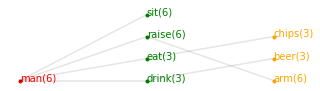

In [17]:
### absorption check
from tools.containers import LayerName
from tools.image_process import getLayerNames
layer = LayerName(getLayerNames('images/Game_day.svg')[-1])#
layer_c = LayerName()
# layer_c.triples_
# print(layer_c.entities_['subj'])
layer_c.absorb(layer)
layer_c.absorb(layer)
layer_c.absorb(layer)
layer_c.triples_
# print(layer)
# print(layer.entities_)
# layer.collapse_subj()
# print(layer.entities_)
# layer.print_()
# layer_c.plot()
print(layer_c.entities_) # plot()
print(layer_c._get_entities())
layer_c.plot()

## exhaustive generator

In [1]:
from models.generator import exhaustivePicGenerator
# import random
for p in exhaustivePicGenerator():
    print(p)

doneimages/product_teardown.svg]   

background 2
surrounding 75
character 87
accessory 14
combs 400
#background; #wild(have[leaf,hole]); #woman(hold[lantern]); #accessory(have[circle,square])
#background; #wild(have[leaf,hole]); #woman(hold[lantern]); #accessory(have[leaf,plant])
#background; #wild(have[leaf,hole]); #woman(sit,play_with[computer]); #accessory(have[circle,square])
#background; #wild(have[leaf,hole]); #woman(sit,play_with[computer]); #accessory(have[leaf,plant])
#background; #wild(have[leaf,hole]); #woman(sit,hold[pizza]); #accessory(have[circle,square])
#background; #wild(have[leaf,hole]); #woman(sit,hold[pizza]); #accessory(have[leaf,plant])
#background; #wild(have[leaf,hole]); #group(have[woman(stand,hold[card]),woman(stand),woman(stand,hold[card]),woman(stand,hold[card])]); #accessory(have[circle,square])
#background; #wild(have[leaf,hole]); #group(have[woman(stand,hold[card]),woman(stand),woman(stand,hold[card]),woman(stand,hold[card])]); #accessory(have[leaf,plant

#other(have[computer,plant,leaf]); #group(have[woman(talk),man(listen)]); #accessory(have[leaf,plant])
#other(have[computer,plant,leaf]); #woman(sit,hold[flower]); #accessory(have[circle,square])
#other(have[computer,plant,leaf]); #woman(sit,hold[flower]); #accessory(have[leaf,plant])
#other(have[computer,plant,leaf]); #man(stand,walk); #accessory(have[circle,square])
#other(have[computer,plant,leaf]); #man(stand,walk); #accessory(have[leaf,plant])
#wild(have[firework,plant]); #woman(hold[lantern]); #accessory(have[circle,square])
#wild(have[firework,plant]); #woman(hold[lantern]); #accessory(have[leaf,plant])
#wild(have[firework,plant]); #woman(sit,play_with[computer]); #accessory(have[circle,square])
#wild(have[firework,plant]); #woman(sit,play_with[computer]); #accessory(have[leaf,plant])
#wild(have[firework,plant]); #woman(sit,hold[pizza]); #accessory(have[circle,square])
#wild(have[firework,plant]); #woman(sit,hold[pizza]); #accessory(have[leaf,plant])
#wild(have[firework,plant]);